<a href="https://colab.research.google.com/github/rachanashinde15/DemoGIt/blob/master/Resnet_Thesis_Final_7layeroutput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers


In [2]:
# Adding TF Cifar10 Data ..
from keras.datasets import cifar100
(X_train, Y_train), (X_test, Y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 13s 0us/step


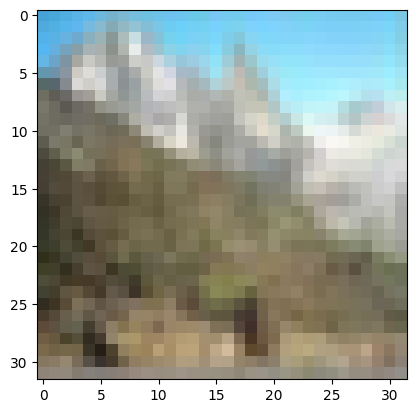

In [3]:
# Drawing sample . 
plt.imshow(X_train[42])

In [4]:
# Normalize the data.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [6]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [7]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [14]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out


In [15]:
model = ResNet18(100)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_30 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_block_12 (ResnetBloc  multiple                 74368     
 k)                                                              
                                                  

In [16]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=50, validation_data=(X_train, Y_train),callbacks=[es])

Epoch 1/50
157/156 [==============================] - ETA: 0s - loss: 3.6472 - accuracy: 0.1542

156/156 [==============================] - 40s 173ms/step - loss: 3.6472 - accuracy: 0.1542 - val_loss: 5.0646 - val_accuracy: 0.0661
Epoch 2/50
157/156 [==============================] - ETA: 0s - loss: 3.0060 - accuracy: 0.2553

156/156 [==============================] - 25s 163ms/step - loss: 3.0060 - accuracy: 0.2553 - val_loss: 4.2618 - val_accuracy: 0.1370
Epoch 3/50
157/156 [==============================] - ETA: 0s - loss: 2.6954 - accuracy: 0.3169

156/156 [==============================] - 25s 160ms/step - loss: 2.6954 - accuracy: 0.3169 - val_loss: 3.2050 - val_accuracy: 0.2385
Epoch 4/50
157/156 [==============================] - ETA: 0s - loss: 2.4606 - accuracy: 0.3641

156/156 [==============================] - 25s 162ms/step - loss: 2.4606 - accuracy: 0.3641 - val_loss: 2.7394 - val_accuracy: 0.3216
Epoch 5/50
157/156 [==============================] - ETA: 0s - loss: 2.2525 - accuracy: 0.4051

156/156 [==============================] - 25s 162ms/step - loss: 2.2525 - accuracy: 0.4051 - val_loss: 2.3856 - val_accuracy: 0.3747
Epoch 6/50
157/156 [==============================] - ETA: 0s - loss: 2.0758 - accuracy: 0.4426

156/156 [==============================] - 26s 164ms/step - loss: 2.0758 - accuracy: 0.4426 - val_loss: 2.3680 - val_accuracy: 0.3889
Epoch 7/50
157/156 [==============================] - ETA: 0s - loss: 1.9215 - accuracy: 0.4778

156/156 [==============================] - 26s 164ms/step - loss: 1.9215 - accuracy: 0.4778 - val_loss: 2.0618 - val_accuracy: 0.4503
Epoch 8/50
157/156 [==============================] - ETA: 0s - loss: 1.7936 - accuracy: 0.5077

156/156 [==============================] - 24s 155ms/step - loss: 1.7936 - accuracy: 0.5077 - val_loss: 2.0299 - val_accuracy: 0.4608
Epoch 9/50
156/156 [============================>.] - ETA: 0s - loss: 1.6511 - accuracy: 0.5394

156/156 [==============================] - 24s 155ms/step - loss: 1.6515 - accuracy: 0.5394 - val_loss: 1.7032 - val_accuracy: 0.5261
Epoch 10/50
157/156 [==============================] - ETA: 0s - loss: 1.5395 - accuracy: 0.5663

156/156 [==============================] - 25s 157ms/step - loss: 1.5395 - accuracy: 0.5663 - val_loss: 1.7457 - val_accuracy: 0.5139
Epoch 11/50
157/156 [==============================] - ETA: 0s - loss: 1.4067 - accuracy: 0.5991

156/156 [==============================] - 25s 162ms/step - loss: 1.4067 - accuracy: 0.5991 - val_loss: 1.4094 - val_accuracy: 0.5967
Epoch 12/50
157/156 [==============================] - ETA: 0s - loss: 1.2913 - accuracy: 0.6314

156/156 [==============================] - 24s 156ms/step - loss: 1.2913 - accuracy: 0.6314 - val_loss: 1.5244 - val_accuracy: 0.5702
Epoch 13/50
157/156 [==============================] - ETA: 0s - loss: 1.1862 - accuracy: 0.6574

156/156 [==============================] - 26s 168ms/step - loss: 1.1862 - accuracy: 0.6574 - val_loss: 1.0379 - val_accuracy: 0.6970
Epoch 14/50
157/156 [==============================] - ETA: 0s - loss: 1.0545 - accuracy: 0.6924

156/156 [==============================] - 25s 163ms/step - loss: 1.0545 - accuracy: 0.6924 - val_loss: 1.6133 - val_accuracy: 0.5658
Epoch 15/50
157/156 [==============================] - ETA: 0s - loss: 0.9604 - accuracy: 0.7173

156/156 [==============================] - 24s 155ms/step - loss: 0.9604 - accuracy: 0.7173 - val_loss: 1.2586 - val_accuracy: 0.6334
Epoch 16/50
157/156 [==============================] - ETA: 0s - loss: 0.8507 - accuracy: 0.7486

156/156 [==============================] - 26s 165ms/step - loss: 0.8507 - accuracy: 0.7486 - val_loss: 0.8533 - val_accuracy: 0.7419
Epoch 17/50
157/156 [==============================] - ETA: 0s - loss: 0.7796 - accuracy: 0.7632

156/156 [==============================] - 25s 157ms/step - loss: 0.7796 - accuracy: 0.7632 - val_loss: 1.1143 - val_accuracy: 0.6776
Epoch 18/50
157/156 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.7917

156/156 [==============================] - 25s 159ms/step - loss: 0.6904 - accuracy: 0.7917 - val_loss: 0.6721 - val_accuracy: 0.7962
Epoch 19/50
157/156 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.8102

156/156 [==============================] - 25s 158ms/step - loss: 0.6221 - accuracy: 0.8102 - val_loss: 0.8934 - val_accuracy: 0.7321
Epoch 20/50
157/156 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.8302

156/156 [==============================] - 25s 158ms/step - loss: 0.5563 - accuracy: 0.8302 - val_loss: 0.6222 - val_accuracy: 0.8059
Epoch 21/50
157/156 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.8507

156/156 [==============================] - 24s 156ms/step - loss: 0.4918 - accuracy: 0.8507 - val_loss: 0.6076 - val_accuracy: 0.8136
Epoch 22/50
157/156 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.8604

156/156 [==============================] - 26s 165ms/step - loss: 0.4521 - accuracy: 0.8604 - val_loss: 0.4663 - val_accuracy: 0.8538
Epoch 23/50
157/156 [==============================] - ETA: 0s - loss: 0.4055 - accuracy: 0.8740

156/156 [==============================] - 25s 159ms/step - loss: 0.4055 - accuracy: 0.8740 - val_loss: 0.5136 - val_accuracy: 0.8391
Epoch 24/50
157/156 [==============================] - ETA: 0s - loss: 0.3764 - accuracy: 0.8830

156/156 [==============================] - 26s 163ms/step - loss: 0.3764 - accuracy: 0.8830 - val_loss: 0.4810 - val_accuracy: 0.8471
Epoch 25/50
157/156 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.8925

156/156 [==============================] - 26s 164ms/step - loss: 0.3455 - accuracy: 0.8925 - val_loss: 0.3459 - val_accuracy: 0.8889
Epoch 26/50
157/156 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.9046

156/156 [==============================] - 25s 158ms/step - loss: 0.3085 - accuracy: 0.9046 - val_loss: 0.5079 - val_accuracy: 0.8368
Epoch 27/50
157/156 [==============================] - ETA: 0s - loss: 0.2899 - accuracy: 0.9092

156/156 [==============================] - 25s 163ms/step - loss: 0.2899 - accuracy: 0.9092 - val_loss: 0.3727 - val_accuracy: 0.8823
Epoch 28/50
157/156 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.9146

156/156 [==============================] - 25s 158ms/step - loss: 0.2675 - accuracy: 0.9146 - val_loss: 0.3582 - val_accuracy: 0.8851
Epoch 29/50
157/156 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.9105

156/156 [==============================] - 25s 158ms/step - loss: 0.2779 - accuracy: 0.9105 - val_loss: 0.4201 - val_accuracy: 0.8687
Epoch 30/50
157/156 [==============================] - ETA: 0s - loss: 0.2641 - accuracy: 0.9161

156/156 [==============================] - 26s 165ms/step - loss: 0.2641 - accuracy: 0.9161 - val_loss: 0.2677 - val_accuracy: 0.9144
Epoch 31/50
157/156 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.9245

156/156 [==============================] - 24s 155ms/step - loss: 0.2397 - accuracy: 0.9245 - val_loss: 0.2578 - val_accuracy: 0.9177
Epoch 32/50
157/156 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9324

156/156 [==============================] - 24s 157ms/step - loss: 0.2133 - accuracy: 0.9324 - val_loss: 0.5975 - val_accuracy: 0.8221
Epoch 33/50
156/156 [============================>.] - ETA: 0s - loss: 0.2106 - accuracy: 0.9321

156/156 [==============================] - 24s 155ms/step - loss: 0.2107 - accuracy: 0.9320 - val_loss: 0.2851 - val_accuracy: 0.9105
Epoch 34/50
157/156 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.9240

156/156 [==============================] - 24s 155ms/step - loss: 0.2341 - accuracy: 0.9240 - val_loss: 0.3725 - val_accuracy: 0.8795
Epoch 35/50
157/156 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9287

156/156 [==============================] - 25s 158ms/step - loss: 0.2187 - accuracy: 0.9287 - val_loss: 0.3563 - val_accuracy: 0.8871
Epoch 36/50
157/156 [==============================] - ETA: 0s - loss: 0.1874 - accuracy: 0.9405

156/156 [==============================] - 25s 161ms/step - loss: 0.1874 - accuracy: 0.9405 - val_loss: 0.2412 - val_accuracy: 0.9216
Epoch 37/50
157/156 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9452

156/156 [==============================] - 25s 159ms/step - loss: 0.1739 - accuracy: 0.9452 - val_loss: 0.2291 - val_accuracy: 0.9269
Epoch 38/50
157/156 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9358

156/156 [==============================] - 25s 159ms/step - loss: 0.1969 - accuracy: 0.9358 - val_loss: 0.5126 - val_accuracy: 0.8456
Epoch 39/50
157/156 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.9410

156/156 [==============================] - 26s 165ms/step - loss: 0.1849 - accuracy: 0.9410 - val_loss: 0.2962 - val_accuracy: 0.9044
Epoch 40/50
157/156 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9435

156/156 [==============================] - 26s 170ms/step - loss: 0.1772 - accuracy: 0.9435 - val_loss: 0.2589 - val_accuracy: 0.9167
Epoch 41/50
157/156 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.9489

156/156 [==============================] - 26s 165ms/step - loss: 0.1624 - accuracy: 0.9489 - val_loss: 0.1596 - val_accuracy: 0.9470
Epoch 42/50
157/156 [==============================] - ETA: 0s - loss: 0.1482 - accuracy: 0.9531

156/156 [==============================] - 24s 155ms/step - loss: 0.1482 - accuracy: 0.9531 - val_loss: 0.2943 - val_accuracy: 0.9089
Epoch 43/50
157/156 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9474

156/156 [==============================] - 25s 157ms/step - loss: 0.1599 - accuracy: 0.9474 - val_loss: 0.4373 - val_accuracy: 0.8660
Epoch 44/50
157/156 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9463

156/156 [==============================] - 26s 164ms/step - loss: 0.1687 - accuracy: 0.9463 - val_loss: 0.2391 - val_accuracy: 0.9242
Epoch 45/50
157/156 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9488

156/156 [==============================] - 25s 159ms/step - loss: 0.1592 - accuracy: 0.9488 - val_loss: 0.7895 - val_accuracy: 0.7978
Epoch 46/50
157/156 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.9545

156/156 [==============================] - 27s 171ms/step - loss: 0.1397 - accuracy: 0.9545 - val_loss: 0.2124 - val_accuracy: 0.9309
Epoch 47/50
157/156 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9559

156/156 [==============================] - 27s 172ms/step - loss: 0.1377 - accuracy: 0.9559 - val_loss: 0.4691 - val_accuracy: 0.8605
Epoch 48/50
157/156 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9575

156/156 [==============================] - 25s 158ms/step - loss: 0.1338 - accuracy: 0.9575 - val_loss: 0.5019 - val_accuracy: 0.8594
Epoch 49/50
157/156 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9492

156/156 [==============================] - 26s 164ms/step - loss: 0.1611 - accuracy: 0.9492 - val_loss: 0.4635 - val_accuracy: 0.8624
Epoch 50/50
157/156 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9434

156/156 [==============================] - 27s 170ms/step - loss: 0.1735 - accuracy: 0.9434 - val_loss: 0.1950 - val_accuracy: 0.9359


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


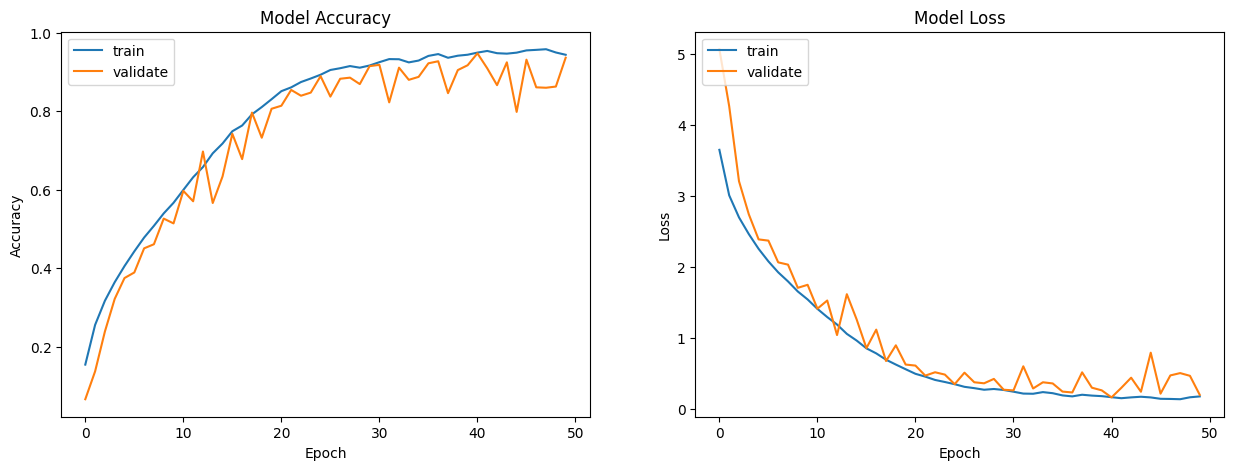

In [18]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [19]:

ModelLoss, ModelAccuracy = model.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 9s 7ms/step - loss: 0.1950 - accuracy: 0.9359
Model Loss is 0.19500066339969635
Model Accuracy is 0.9358999729156494


In [20]:
# Assuming you have trained the model and stored it in the 'model' variable
from sklearn.metrics import confusion_matrix
# Make predictions on the test set
Y_pred = model.predict(X_test)
# Convert the one-hot encoded predictions and true labels to their original form
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(Y_true_labels, Y_pred_labels)
print("Confusion Matrix:")
print(confusion_mat)


313/313 [==============================] - 2s 5ms/step
Confusion Matrix:
[[76  2  0 ...  0  0  1]
 [ 1 52  1 ...  0  0  1]
 [ 0  0 34 ...  0 10  0]
 ...
 [ 0  0  0 ... 37  1  3]
 [ 2  1  2 ...  0 34  5]
 [ 0  0  0 ...  0  1 69]]


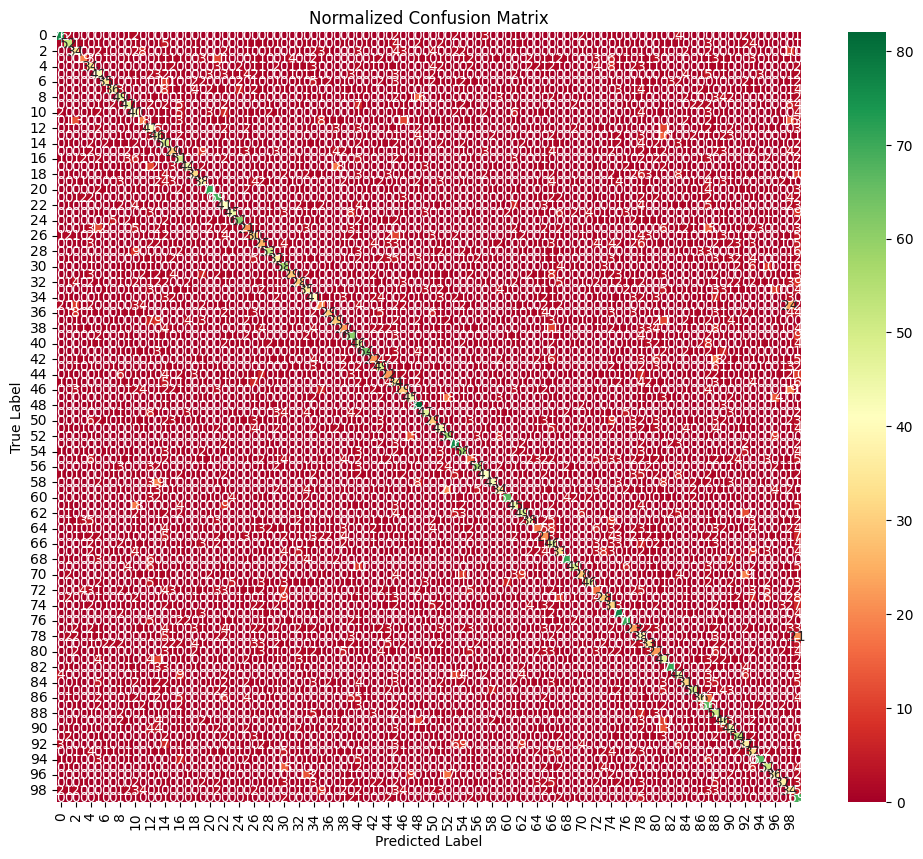

In [21]:
# Define class labels
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mat, annot=True, cmap='RdYlGn', fmt='d')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [22]:
from sklearn.metrics import classification_report

# Assuming you have the true labels 'y_true' and predicted labels 'y_pred'

# Generate classification report
report = classification_report(Y_pred_labels,Y_true_labels)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.76      0.79      0.78        96
           1       0.52      0.61      0.56        85
           2       0.34      0.34      0.34       101
           3       0.19      0.43      0.26        44
           4       0.34      0.31      0.33       109
           5       0.42      0.38      0.40       110
           6       0.35      0.69      0.46        51
           7       0.36      0.64      0.46        56
           8       0.49      0.48      0.48       103
           9       0.47      0.56      0.51        84
          10       0.40      0.30      0.34       133
          11       0.18      0.32      0.23        56
          12       0.41      0.30      0.34       138
          13       0.46      0.29      0.35       160
          14       0.50      0.27      0.35       188
          15       0.29      0.43      0.35        67
          16       0.51      0.38      0.44       133
          17       0.44    